### <u>Cross-Clustered Models</u>
The varying effects with grouping by province worked relatively well, but some of the data, e.g. in the CARB and NWCS provinces show some complex structure that might benefit from more multiple grouping. Moreover, both model comparison methods, the WAIC and LOOCV, flagged max(blue) based clustering as potentially useful in combination with the province-based clustering. In this post I will further the analysis with two cross-classified models. Cross-classified models feature more than one groupings in paralle. Here I will use two pairs of groupings to develop two different models. The first model combines the max(blue) grouping with the province grouping. For good measure, I'll implement a second model combining max(blue) and biome grouping. For both models and for both groupings, I will implement covarying effects, since these offer some improvement on the fit.

In [1]:
import pickle
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, kdeplot, jointplot, FacetGrid
import theano.tensor as tt
import re
from matplotlib import cm
from cmocean import cm as cmo
from matplotlib.colors import rgb2hex
from sklearn.preprocessing import StandardScaler

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Setting graphics...
% matplotlib inline
pl.style.use('bmh')
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18

In [3]:
df = pd.read_pickle('./pickleJar/df_log.pkl')
df.head().T

,0,1,2,3,4
id,4045,4056,4057,5949,5950
datetime,1998-08-29 17:55:00,1998-09-02 15:52:00,1998-09-02 18:10:00,1997-10-12 23:38:00,1997-10-13 18:33:00
lat,60.587,60.674,60.604,59.118,58.792
lon,-146.409,-147.682,-147.205,-148.677,-148.493
etopo2_l,1.91381,1.14613,2.02938,2.15534,2.45637
oisst,13.04,11.74,11.74,9.71,9.84
sal_l,NaN,NaN,NaN,NaN,NaN
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778


In [4]:
blue_mapping = dict(enumerate(df['mxBlId'].astype('category').cat.categories))
biome_mapping = dict(enumerate(df['biome'].astype('category').cat.categories))
prov_mapping = dict(enumerate(df['provCode'].astype('category').cat.categories))

In [5]:
d_ = df[['mxBlId','provCat','mxBlCat', 'biomCat', 'MxBl-Gr',
         'oisst', 'etopo2_l', 'chl', 'chl_l']].dropna()
d_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 0 to 4458
Data columns (total 9 columns):
mxBlId      4126 non-null object
provCat     4126 non-null int8
mxBlCat     4126 non-null int8
biomCat     4126 non-null int8
MxBl-Gr     4126 non-null float64
oisst       4126 non-null float64
etopo2_l    4126 non-null float64
chl         4126 non-null float64
chl_l       4126 non-null float64
dtypes: float64(5), int8(3), object(1)
memory usage: 237.7+ KB


In [6]:
n_provinces = d_.provCat.unique().size
n_blues = d_.mxBlCat.unique().size
n_biomes = d_.biomCat.unique().size
provIdx = d_.provCat.values
blueIdx = d_.mxBlCat.values
biomeIdx = d_.biomCat.values
log_band_ratio = d_['MxBl-Gr'].values
log_depth = d_['etopo2_l'].values
sst = d_['oisst'].values
predicted = d_['chl_l'].values

In [7]:
standard_scaler = StandardScaler()
log_band_ratio_s = standard_scaler.fit_transform(log_band_ratio.reshape(-1, 1))

In [9]:
with pm.Model() as mdl_pr_bl:
    
    # hyperpriors
    # -----------
    # province cluster hyperpriors
    a_prov_mean_hyp = pm.Normal('a_prov_mean_hyp', 0, 10)
    a_prov_sd_hyp = pm.HalfNormal('a_prov_sd_hyp', 2)
    b_prov_mean_hyp = pm.Normal('b_prov_mean_hyp', 0, 10)
    b_prov_sd_hyp = pm.HalfNormal('b_prov_sd_hyp', 2)
    
    # blue cluster hyperpriors
    a_blue_mean_hyp = pm.Normal('a_blue_mean_hyp', 0, 10)
    a_blue_sd_hyp = pm.HalfNormal('a_blue_sd_hyp', 2)
    b_blue_mean_hyp = pm.Normal('b_blue_mean_hyp', 0, 10)
    b_blue_sd_hyp = pm.HalfNormal('b_blue_sd_hyp', 2)
    
    # priors
    a_prov = pm.Normal('a_prov', mu=a_prov_mean_hyp,
                       sd=a_prov_sd_hyp, shape=n_provinces)
    a_blue = pm.Normal('a_blue', mu=a_blue_mean_hyp,
                       sd=a_blue_sd_hyp, shape=n_blues)
    b_prov = pm.Normal('b_prov', mu=b_prov_mean_hyp,
                      sd=b_prov_sd_hyp, shape=n_provinces)
    b_blue = pm.Normal('b_blue', mu=b_prov_mean_hyp,
                      sd=b_prov_sd_hyp, shape=n_blues)
    a_global = pm.Normal('a_global', 0, sd=1)
    b_global = pm.Normal('b_global', 0, sd=1)
    eps = pm.HalfNormal('eps', 2)
    intercept = a_global + a_blue[blueIdx] + a_prov[provIdx]
    slope = b_global + b_blue[blueIdx] + b_prov[provIdx]
    mu_ = intercept + slope * log_band_ratio
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl_pr = pm.sample(5000, tune=5000,
                            nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_global, a_global, b_blue, b_prov, a_blue, a_prov, b_blue_sd_hyp_log__, b_blue_mean_hyp, a_blue_sd_hyp_log__, a_blue_mean_hyp, b_prov_sd_hyp_log__, b_prov_mean_hyp, a_prov_sd_hyp_log__, a_prov_mean_hyp]
  1%|          | 114/10000 [00:09<14:20, 11.49it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
 10%|█         | 1023/10000 [05:05<44:39,  3.35it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
 

KeyboardInterrupt: 

In [18]:
with pm.Model() as mdl_pr_bl_nc:
    
    # hyperpriors
    # -----------
    # province cluster hyperpriors
    a_prov_mean_hyp = pm.Normal('a_prov_mean_hyp', 0, 1000)
    a_prov_sd_hyp = pm.HalfCauchy('a_prov_sd_hyp', 2)
    b_prov_mean_hyp = pm.Normal('b_prov_mean_hyp', 0, 1000)
    b_prov_sd_hyp = pm.HalfCauchy('b_prov_sd_hyp', 2)
    
    # blue cluster hyperpriors
    a_blue_mean_hyp = pm.Normal('a_blue_mean_hyp', 0, 1000)
    a_blue_sd_hyp = pm.HalfCauchy('a_blue_sd_hyp', 2)
    b_blue_mean_hyp = pm.Normal('b_blue_mean_hyp', 0, 1000)
    b_blue_sd_hyp = pm.HalfCauchy('b_blue_sd_hyp', 2)
    
    # priors
    a_prov = pm.Normal('a_prov', mu=0, sd=100, shape=n_provinces)
    a_blue = pm.Normal('a_blue', mu=0, sd=100, shape=n_blues)
    b_prov = pm.Normal('b_prov', mu=0, sd=100, shape=n_provinces)
    b_blue = pm.Normal('b_blue', mu=0, sd=100, shape=n_blues)
    a_prov_offset = a_prov_mean_hyp + a_prov * a_prov_sd_hyp
    b_prov_offset = b_prov_mean_hyp + b_prov * b_prov_sd_hyp
    a_blue_offset = a_blue_mean_hyp + a_blue * a_blue_sd_hyp
    b_blue_offset = b_blue_mean_hyp + b_blue * b_blue_sd_hyp
    
    #a_global = pm.Normal('a_global', 0, sd=1)
    #b_global = pm.Normal('b_global', 0, sd=1)
    eps = pm.HalfNormal('eps', 10)
    intercept = a_blue_offset[blueIdx] + a_prov_offset[provIdx]
    slope = b_blue_offset[blueIdx] + b_prov_offset[provIdx]
    mu_ = intercept + slope * log_band_ratio
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl_pr_nc = pm.sample(1000, chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps_log__, b_blue, b_prov, a_blue, a_prov, b_blue_sd_hyp_log__, b_blue_mean_hyp, a_blue_sd_hyp_log__, a_blue_mean_hyp, b_prov_sd_hyp_log__, b_prov_mean_hyp, a_prov_sd_hyp_log__, a_prov_mean_hyp]
  9%|▉         | 134/1500 [00:09<01:40, 13.56it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
 23%|██▎       | 338/1500 [01:00<03:26,  5.62it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


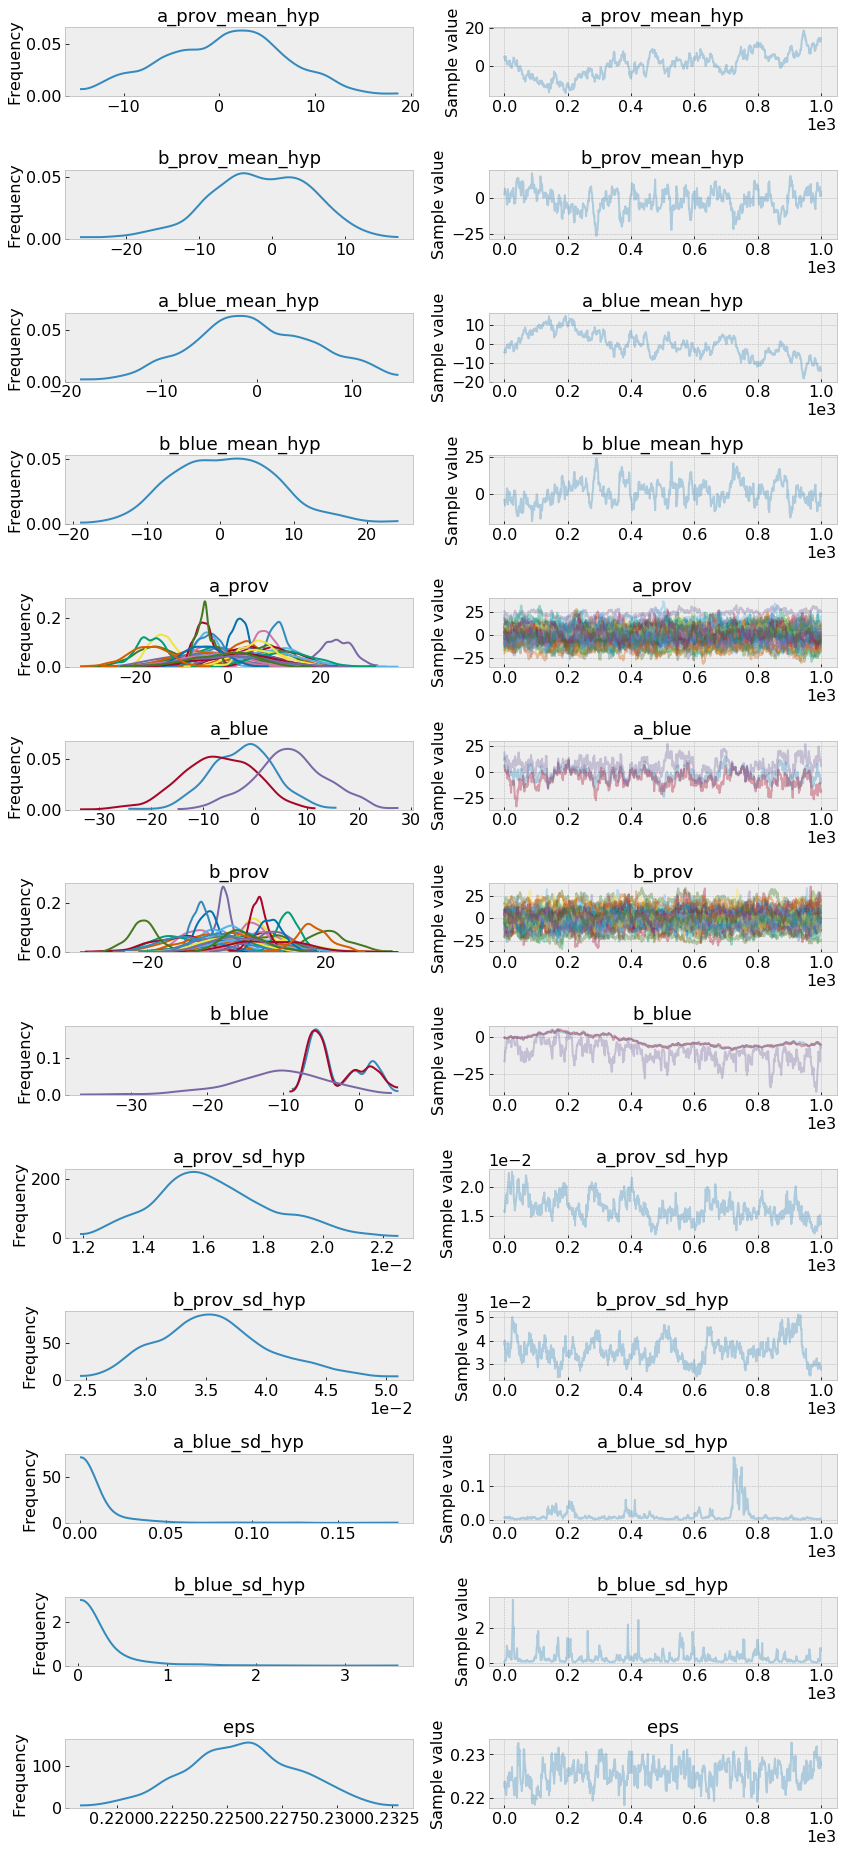

In [17]:
pm.traceplot(trace_bl_pr_nc);